# Experiments on real datasets 

Including preprocessing of data and comparison of different models with different metrics.

#### Datsets used
1. [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))
    - 569 samples (no missing values),
    - 30 features (removed 9 features with correlation > 0.9), 
    - 2 classes
    - 357 benign, 212 malignant
2. [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
    - 891 samples (no missing values),
    - 11 features (removed 2 features with correlation > 0.9), 
    - 2 classes
    - 549 died, 342 survived

#### Metrics used
1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Bootstrap accuracy

#### Models used
1. KNN - K-Nearest Neighbors
2. LDA - Linear Discriminant Analysis
3. Logistic Regression
4. Logistic Regression with IRLS (our model)
5. Logistic Regression with IRLS (our model) with all possible interactions
6. QDA - Quadratic Discriminant Analysis

## Models and metrics

In [1]:
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from LogisticRegressionIRLS import LR
from sklearn.neighbors import KNeighborsClassifier
from functools import partial

class LRWrapper(LR):
    def __init__(self, *args, all_interactions=False, **kwargs):
        self.all_interactions = all_interactions
        super().__init__(*args, **kwargs)

    def fit(self, X, Y):
        X = pd.DataFrame(X)
        Y = Y.reshape(-1, 1)
        if self.all_interactions:
            interactions = [[i, j] for i in range(X.shape[1]) for j in range(i+1, X.shape[1])]
            super().fit(X, Y, interactions=interactions)
        else:
            super().fit(X, Y)
        return self
    
    def predict(self, X):
        X = pd.DataFrame(X)
        Y = super().predict(X)
        return Y

models = {'LDA': LinearDiscriminantAnalysis,
        'QDA': QuadraticDiscriminantAnalysis,
        'Logistic ': LogisticRegression,
        'Logistic IRLS': partial(LRWrapper, maximisation_minorisation=False),
        'Logistic IRLS with interactions': partial(LRWrapper, maximisation_minorisation=False, all_interactions=True),
        'KNN': KNeighborsClassifier}

In [2]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def metric_bootstrap(X, Y, model_class, n=10):
    model = model_class()
    error = 0
    lenght_of_y = 0
    for i in range(n):
        sample_ids = resample(range(len(X)), replace=True, n_samples=len(X))

        test_ids = [i for i in range(len(X)) if i not in sample_ids]
        if len(sample_ids) == len(test_ids):
            i -= 1
            continue
        lenght_of_y += len(test_ids)
        train_ids = [i for i in range(len(X)) if i in sample_ids]
        model.fit(X[train_ids], Y[train_ids])
        y_pred = model.predict(X[test_ids])
        for i in range(len(y_pred)):
            if Y[test_ids[i]] != y_pred[i]:
                error += 1
    error_bootstrap = error / lenght_of_y
    accuracy_bootstrap = 1 - error_bootstrap
    return accuracy_bootstrap

metrics = {'precision': partial(precision_score, zero_division=0),
            'recall': recall_score,
            'accuracy': accuracy_score,
            'f1': f1_score,
            'bootstrap': metric_bootstrap}

## Dataset 1 - Breast Cancer

Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

In [14]:
from sklearn.datasets import load_breast_cancer
X, Y = load_breast_cancer(return_X_y=True)

## Preparing data

In [15]:
from sklearn.preprocessing import OneHotEncoder
from collinearity import SelectNonCollinear
from sklearn.preprocessing import StandardScaler
import numpy as np

def remove_missing_rows(X, Y):
    mask = np.isnan(X).sum(axis=1) == 0
    return X[mask], Y[mask]

def encode_categorical(X):
    mask = np.array([isinstance(x, str) for x in X[0]])
    if mask.sum() > 0:    
        X_masked = X[:, mask]
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(X_masked)
        X_masked = enc.transform(X_masked).toarray()
        X = np.concatenate([X[:, ~mask], X_masked], axis=1)
    return X

def remove_colinear(X, correlation_threshold=0.9):
    # Source: https://github.com/gianlucamalato/collinearity
    # 1. Take the couple of features that have the lowest absolute 
    #    value of the linear correlation coefficient.
    # 2. If it's lower than the threshold, consider these features
    # 3. Keep adding features as long as the correlation matrix doesn't
    #    show off-diagonal elements whose absolute value is greater than the threshold.
    selector = SelectNonCollinear(correlation_threshold=correlation_threshold)
    selector.fit(X, y=None)
    X = selector.transform(X)
    columns_selection = selector.get_support()
    return X, columns_selection   

def scale_features(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

Before preparation:

In [16]:
print(f"In the raw data, there are {X.shape[0]} observations and {X.shape[1]} features.")

In the raw data, there are 569 observations and 30 features.


Dropping rows with missing values, encoding categorical variables, dropping features with correlation > 0.9, and scaling the data.

In [17]:
X, Y = remove_missing_rows(X, Y)
X = encode_categorical(X)
X, columns_selection = remove_colinear(X, correlation_threshold=0.9)

After preparation:

In [18]:
print(f"In the prepared data, there are {X.shape[0]} observations and {X.shape[1]} features (removed {len(columns_selection) - np.array(columns_selection).sum()} features).")

In the prepared data, there are 569 observations and 21 features (removed 9 features).


### Train/Test Split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Experiments

Test run.

In [20]:
import pandas as pd
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)

def train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name='model'):
    model = model_class()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return {'model':model_name} |\
            {metric: metrics[metric](Y_test, Y_pred) for metric in metrics if metric != 'bootstrap'} |\
            {f'bootstrap accuracy': metrics['bootstrap'](X_train, Y_train, model_class)}

def train_models(models, X, Y, metrics, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    results = []
    for model_name, model_class in models.items():
        results.append(train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name=model_name))
    df = pd.DataFrame(results)
    return df

df = train_models(models, X, Y, metrics, test_size=0.2)
df

,model,precision,recall,accuracy,f1,bootstrap accuracy
0,LDA,0.975000,0.987342,0.973684,0.981132,0.949731
1,QDA,0.985915,0.886076,0.912281,0.933333,0.954861
2,Logistic,0.949367,0.949367,0.929825,0.949367,0.932749
3,Logistic IRLS,0.692982,1.000000,0.692982,0.818653,0.510523
4,Logistic IRLS with interactions,0.692982,1.000000,0.692982,0.818653,0.619249
5,KNN,0.936709,0.936709,0.912281,0.936709,0.888422


Repeated 10 times to create boxplots.

In [21]:
from tqdm import tqdm

test_size = 0.6 # it is this high to see differences in the results

df_list = []
for i in tqdm(range(50)):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


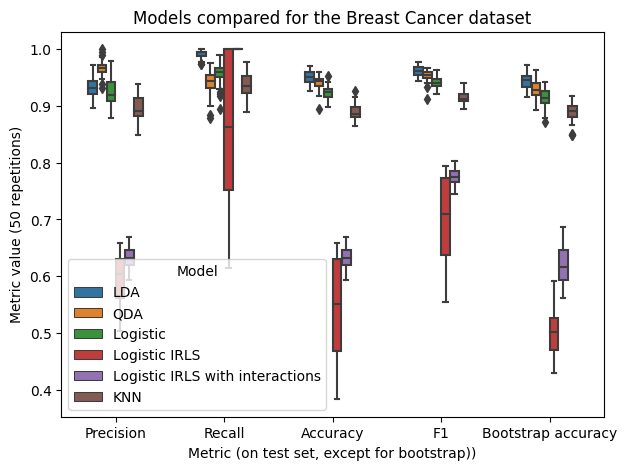

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model', width=0.5)

ax.set_title('Models compared for the Breast Cancer dataset')
ax.set_xlabel('Metric (on test set, except for bootstrap))')
ax.set_ylabel('Metric value (50 repetitions)')
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model')
fig.savefig('models_comparison_1_breast_cancer.png', dpi=300)
plt.show()

## Dataset 2 - Titanic

Source: [Kaggle](https://www.kaggle.com/c/titanic/data)

Columns:
- PassengerId - ID of the passenger
- Survived - Survival (0 = No, 1 = Yes)
- Pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name - Name of the passenger
- Sex - Sex of the passenger
- Age - Age of the passenger
- SibSp - Number of siblings/spouses aboard the Titanic
- Parch - Number of parents/children aboard the Titanic
- Ticket - Ticket number
- Fare - Passenger fare
- Cabin - Cabin number
- Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [3]:
import pandas as pd

df = pd.read_csv('titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X, Y = df.drop('Survived', axis=1).to_numpy(), df['Survived'].to_numpy()

## Preparing data

Columns removed due to their nature:
- PassengerId
- Name
- Ticket

Columns removed due to more than 50% missing values:
- Cabin

In [5]:
from collinearity import SelectNonCollinear
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

def remove_columns(X, column_names):
    mask = np.ones(X.shape[1], dtype=bool)
    columns = [i for i, name in enumerate(df.drop('Survived', axis=1).columns) if name in column_names]
    mask[columns] = False
    return X[:, mask]

def remove_missing_columns(X, threshold=0.5):
    mask = (X != X).sum(axis=0) / X.shape[0] < threshold
    return X[:, mask]

def remove_missing_rows(X, Y):
    mask = (X[:,-1] != X[:,-1])
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

def encode_text(X):
    X[:,1] = np.where(X[:,1] == 'male', -1, X[:,1])
    X[:,1] = np.where(X[:,1] == 'female', 1, X[:,1])
    mask = np.array([isinstance(x, str) for x in X[0]])
    if mask.sum() > 0:    
        X_masked = X[:, mask]
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(X_masked)
        X_masked = enc.transform(X_masked).toarray()
        X_masked = X_masked[:, 1:]
        X = np.concatenate((X[:, ~mask], X_masked), axis=1)
    return X.astype(float)

def impute_missing_age(X):
    imputer = KNNImputer(n_neighbors=5)
    X = imputer.fit_transform(X)
    return X

def remove_colinear(X, correlation_threshold=0.9):
    # Source: https://github.com/gianlucamalato/collinearity
    # 1. Take the couple of features that have the lowest absolute 
    #    value of the linear correlation coefficient.
    # 2. If it's lower than the threshold, consider these features
    # 3. Keep adding features as long as the correlation matrix doesn't
    #    show off-diagonal elements whose absolute value is greater than the threshold.
    selector = SelectNonCollinear(correlation_threshold=correlation_threshold)
    selector.fit(X, y=None)
    X = selector.transform(X)
    columns_selection = selector.get_support()
    return X.astype(int), columns_selection

Before preparation:

In [6]:
print('Before processing: rows: ', X.shape[0], 'columns: ', X.shape[1])
print(X[0], Y[0])
print(X[-1], Y[-1])

Before processing: rows:  891 columns:  11
[1 3 'Braund, Mr. Owen Harris' 'male' 22.0 1 0 'A/5 21171' 7.25 nan 'S'] 0
[891 3 'Dooley, Mr. Patrick' 'male' 32.0 0 0 '370376' 7.75 nan 'Q'] 0


Replace text with numbers.

In [7]:
X = remove_columns(X, ['Name', 'Ticket', 'PassengerId'])
X = remove_missing_columns(X) # will remove the Cabin column
X, Y = remove_missing_rows(X, Y) # remove 2 rows in Embarked column
X = encode_text(X) # sex to -1, 1, embarked one hot encoding
X = impute_missing_age(X) # imputate missing values in Age
X, columns_selection = remove_colinear(X, correlation_threshold=0.9)

After preparation:

In [8]:
print('After processing: rows: ', X.shape[0], 'columns: ', X.shape[1])
print(X[0], Y[0])
print(X[-1], Y[-1])

After processing: rows:  889 columns:  8
[ 3 -1 22  1  0  7  0  1] 0
[ 3 -1 32  0  0  7  1  0] 0


### Train/Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Experiments

Test run.

In [10]:
import pandas as pd
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)

def train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name='model'):
    model = model_class()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return {'model':model_name} |\
            {metric: metrics[metric](Y_test, Y_pred) for metric in metrics if metric != 'bootstrap'} |\
            {f'bootstrap accuracy': metrics['bootstrap'](X_train, Y_train, model_class)}

def train_models(models, X, Y, metrics, test_size):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
    results = []
    for model_name, model_class in models.items():
        results.append(train_model(model_class, X_train, X_test, Y_train, Y_test, metrics, model_name=model_name))
    df = pd.DataFrame(results)
    return df

df = train_models(models, X, Y, metrics, test_size=0.2)
df

,model,precision,recall,accuracy,f1,bootstrap accuracy
0,LDA,0.776119,0.641975,0.752809,0.702703,0.809233
1,QDA,0.830769,0.666667,0.786517,0.739726,0.805364
2,Logistic,0.809524,0.629630,0.764045,0.708333,0.814913
3,Logistic IRLS,0.455056,1.000000,0.455056,0.625483,0.357197
4,Logistic IRLS with interactions,0.455056,1.000000,0.455056,0.625483,0.379284
5,KNN,0.730159,0.567901,0.707865,0.638889,0.702868


Repeated 10 times to create boxplots.

In [11]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

test_size = 0.2

df_list = []
for i in tqdm(range(50)):
    df_list.append(train_models(models, X, Y, metrics, test_size))
df = pd.concat(df_list, ignore_index=True)
df = df.melt(id_vars=['model'], var_name='metric', value_name='value')

100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


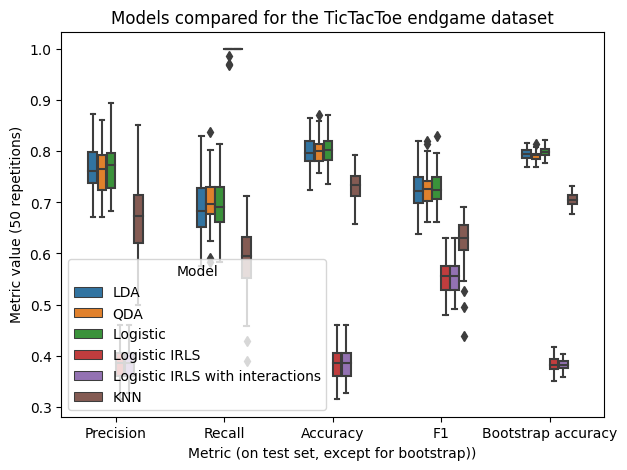

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, ax=ax, x='metric', y='value', hue='model', width=0.5)

ax.set_title('Models compared for the TicTacToe endgame dataset')
ax.set_xlabel('Metric (on test set, except for bootstrap))')
ax.set_ylabel('Metric value (50 repetitions)')
# ax.set_ylim(0.78, 1.01)
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Model')
fig.savefig('models_comparison_2_tictactoe.png', dpi=300)
plt.show()